# VS Code Event Performance

First, let's look at how events are used. I initially hypothesized we'd have a bimodal distribution between listeners with a small number of events, and ones with large number of events.

In reality, it's much closer to a power-law distribution. The plurality of event emitters have no listeners at all, and second most common is a single listener. This data was collected after VS Code started up with an editor open:

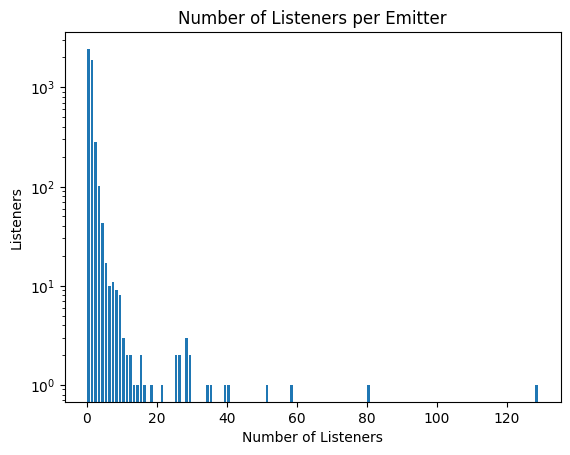

In [14]:
import json
import matplotlib.pyplot as plt

with open('./boot.json') as f:
  data = json.load(f)

plt.hist(data['numListeners'], bins=range(min(data['numListeners']), max(data['numListeners']) + 2, 1), rwidth=0.8)
plt.xlabel('Number of Listeners')
plt.ylabel('Listeners')
plt.title('Number of Listeners per Emitter')
plt.yscale('log')
plt.show()


We can also estimate how long was spent in the delivery mechanics during boot. This is the time to create the delivery queue, not call each individual function, so it slightly **underestimates** the actual time.

In [20]:
total = 0
emissions = 0
for d in data['eventRate']:
  total += d['spent'] - d['deliverySpent']
  emissions += d['emissions']
print('Stats for the first', len(data['eventRate']), 'seconds of the editor:')
print('Time spent in emitter overhead (ms)', round(total, 2))
print('Total number of event emissions:', emissions)

Stats for the first 13 seconds of the editor:
Time spent in emitter overhead (ms) 33.0
Total number of event emissions: 13882


Finally, let's look at memory usage once the editor is in a steady opened state. This is counting the direct utilization of the Emitters and its linked list nodes.

From a heap snapshot, I manually tallied memory usage per for emitters, which comes to a total usage of:

In [37]:
zero_listener_emitter = 76
linked_list_overhead = 24
bytes_per_emitter = 24
memory = 0
for n in data['numListeners']:
    if n == 0:
      memory += zero_listener_emitter
    else:
      memory += linked_list_overhead + n * bytes_per_emitter
print("Memory usage:", memory / 1024, "KB")

Memory usage: 335.11328125 KB
